# *Importing relevent libraries*

In [2]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

Using sympy to set up time , mass and length symbols(independent variables)

In [3]:
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m1 m2')
L1, L2 = smp.symbols('L1 L2')

Defining the angle variables(independent variables, funcgtion of time)

In [4]:
theta1, theta2 = smp.symbols(r'\theta_1, \theta_2', cls=smp.Function)

Defining them explicitly as a function of time *t*

In [5]:
the1 = theta1(t)
the2 = theta2(t)

Defining first and second derivative

In [9]:
the1_d = smp.diff(the1,t)
the2_d = smp.diff(the2,t)
the1_dd = smp.diff(the1_d,t)
the2_dd = smp.diff(the2_d,t)

Defining x1 , y1 , x2 and y2 in terms of the angle(theta) taking the point on the wall and the rod 1 as the origin(cartesian coordinates) used to define kinetic and  potential energy

---



In [10]:
x1 = L1*smp.sin(the1)
y1 = -L1*smp.cos(the1)
x2 = L1*smp.sin(the1) + L2*smp.sin(the2)
y2 = -L1*smp.cos(the1) - L2*smp.cos(the2)

Plan : 1) Kinetic energy and potential energy -> 2) gives us lagrangian ->
3) gives us langragian equation of motion -> 4) Solving the differential equations

1) Kinetic energy and potential energy

In [11]:
# Kinetic Energy
T1 = 1/2 * m1 * ((smp.diff(x1,t))**2 + (smp.diff(y1,t))**2)
T2 = 1/2 * m2 * ((smp.diff(x2,t))**2 + (smp.diff(y2,t))**2)
T = T1 + T2
# Potential Energy
V1 = m1*g*y1
V2 = m2*g*y2
V = V1 + V2

2) Defining the lagrangian

In [12]:
# Lagrangian
L = T - V

Writing a diferential equation

In [13]:
#example of a differential equation
# where we write a simple differential equation
from math import *

x = smp.symbols('x')
y = smp.Function('y')
diffeq = smp.Eq(y(x).diff(x), smp.sin(x))


3)Getting the differential equations 
<br/>
<br/>
Lagrange's Equations

$\frac{\partial L}{\partial Θ_1} - \frac{\partial }{\partial t}(\frac{\partial L}{\partial \dot{Θ_1}}) = 0$

$\frac{\partial L}{\partial Θ_2} - \frac{\partial }{\partial t}(\frac{\partial L}{\partial \dot{Θ_2}}) = 0$

In [14]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d),t).simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d),t).simplify()

4) Solving the differential equation

Equation LE1 and LE2 is equal to zero and So we can write the second derivative of theta 1 and theta 2 in terms of other variables and the first derivative of theta 1 and first derivative of theta 2.

In [15]:
#So we have 2 equations and 2 variables(second derivative of thetas)
sols = smp.solve([LE1, LE2], (the1_dd, the2_dd),simplify=False, rational=False)

In [16]:
#The first derivative :
#sols[the1_dd]



#The second derivative :
#sols[the2_dd]


So  we have the second derivatives of thetas
<br/>
<br/>
<br/>

$\frac{d^2 Θ_1}{d t^2}=...$
<br/>
$\frac{d^2 Θ_2}{d t^2}=...$
<br/>
In python we cannot solve 2nd order differential equation, In python we can only solve 1st order ODEs , So we have to convert the above 2nd order equation into 1st order equation by substitution .
we will take : <br/> $z_1 = \frac{d Θ_1}{d t} $ ,$\frac{d z_1}{d t} =  \frac{d^2 Θ_1}{d t^2}$ <br/> $z_2 = \frac{d Θ_2}{d t} $ ,$\frac{d z_2}{d t} =  \frac{d^2 Θ_2}{d t^2}$
<br/> We have a system of 4 first order ODEs:<br/>

*   $\frac{d z_1}{d t} = ....$
*   $z_1 = \frac{d Θ_1}{d t} $
*   $\frac{d z_2}{d t} = ....$
*   $z_2 = \frac{d Θ_2}{d t} $






Now we will convert the symbolic representation in numerical expression, So that python can solve it using numerical methods 

In [17]:
dz1dt_N = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the1_dd])
dz2dt_N = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the2_dd])
dthe1dt_N = smp.lambdify(the1_d, the1_d)
dthe2dt_N = smp.lambdify(the2_d, the2_d) 

In [18]:
dz1dt_N(2,9.81,1,1,1,1,4,2,5,3)
# = 6.794698310198159


6.794698310198159

We will now define $\vec{S} = (Θ_1, z_1,Θ_2,z_2)$, $\vec{S}$ will contain all variables that we have to find. In ODE solver in python we have to define $\frac{d \vec{S}}{d t}$, So we will make a function **dSdt** for this.<br/>$\frac{d \vec{S}}{d t}$ dependes only on $\vec{S}$ and $t$

In [19]:
def dSdt(S, t, g, m1, m2, L1, L2):
  the1, z1, the2, z2 = S
  return [
          dthe1dt_N(z1),
          dz1dt_N(t,g,m1,m2,L1,L2,the1,the2,z1,z2),
          dthe2dt_N(z2),
          dz2dt_N(t,g,m1,m2,L1,L2,the1,the2,z1,z2)
  ]

Solving the ODEs using **scipys odeint method**

In [20]:
t = np.linspace(0, 40, 1001)
g = 9.81
m1 = 2
m2 = 1
L1 = 2
L2 = 1
ans = odeint(dSdt, y0=[1,-3,-1,5], t=t, args=(g,m1,m2,L1,L2))

To find the frame rate we will find how mnty data points are in 1 sec 

In [21]:
len(t[t<1])
#25 here in this example 25 is the frame rate
# 25 = 1000/40

25

We obtain $\theta_1$ and $\theta_2$ afetr transposing the ans matrix

In [22]:
Theta_1 = ans.T[0]
Theta_2 = ans.T[2]

now plotting the Theta_1 and Theta_2 in matplotlib we get 

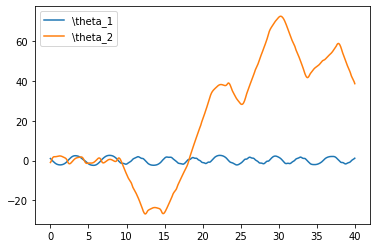

In [23]:
plt.plot(t, Theta_1,label=theta1)
plt.plot(t, Theta_2,label=theta2)
plt.legend()
plt.show()

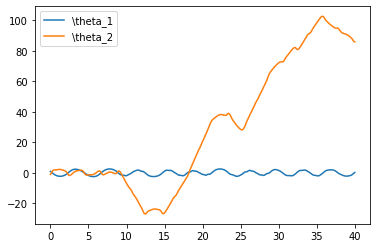


This is the plot of theta_1 vs time and Theta_2 vs time

Just using theta_1 and theta_2 values we have all the information about the position of the masses and so we can now animate using these arrays.

So now we will create a function that takes $\theta_1 , \theta_2, L1, L2, and \:t$ where $t$ is the time array and will return the coordinates of the masses in the cartesian format.

In [30]:
def get_x1y1x2y2(t, Theta_1, Theta_2, L1, L2):
  return (L1*np.sin(Theta_1),
          -L1*np.cos(Theta_1),
          L1*np.sin(Theta_1) + L2*np.sin(Theta_2),
          -L1*np.cos(Theta_1) - L2*np.cos(Theta_2))
x1, y1, x2, y2 = get_x1y1x2y2(t, ans.T[0],ans.T[2],L1,L2)
  

Now we can start animating


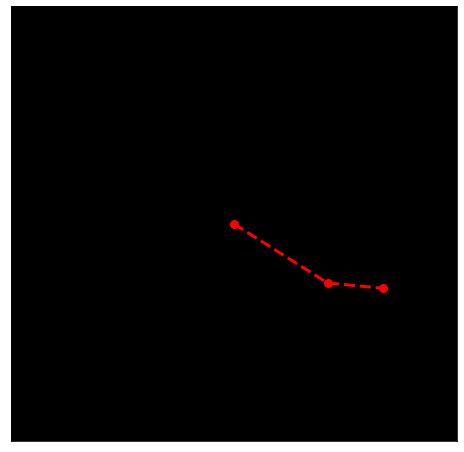

In [33]:
#animation function takes argumnet as the nth frame of the animation

def animate(i):
  ln1.set_data([0, x1[i],x2[i]],[0,y1[i],y2[i]])
  # here 0 before the x1 , x2  and 0 before y1, y2 signifies the origin
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([]) #hides the x ticks 
ax.get_yaxis().set_ticks([]) #hides the y ticks
ln1, = plt.plot([],[],'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig,animate, frames=1000, interval=50)
# here 'frames' argument is the total number of frames in the animation 
ani.save('pen.gif', writer='pillow',fps=25)


In [28]:
#from IPython.display import HTML 
#HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [35]:
#uncomment the following code to see the animation in slider and then to open the slider just run ani

from matplotlib import rc
rc('animation', html='jshtml')
ani